# Classifiez automatiquement des biens de consommation

In [1]:
!python --version

Python 3.7.13


**Mission principale** : réaliser une première étude faisabilité d'un moteur de classification basé sur les images et les descriptions de l’entreprise "*Place de marché*"

In [1]:
!pip install fuzzywuzzy
#utilisation d'une version adapter pour sift
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

# Tensorflows
!pip install keras
!pip install tensorflow

     |████████████████████████████████| 25.0 MB 62.7 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 95 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 462 kB 4.4 MB/s 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from fuzzywuzzy import fuzz

import cv2
import time
from sklearn import cluster, metrics
#img
from PIL import Image
from matplotlib.image import imread
from sklearn import manifold #TSNE
from matplotlib import offsetbox
from sklearn import preprocessing, manifold, decomposition
from os import listdir #se mettre dans un repertoire
import plotly.graph_objects as go
from skimage import io
from sklearn.metrics import confusion_matrix
#from google.colab import drive
from sklearn.model_selection import train_test_split

# Librairies tensorflow
from tensorflow.python.keras.models import Model,Sequential
from tensorflow.python.keras import losses
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

/home/bdiallo/miniconda3/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2022-04-15 12:49:21.879271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bdiallo/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-15 12:49:21.879293: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
print(cv2.__version__)

3.4.2


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
link="/content/drive/My Drive/P6_DIALLO_Fatoumata/Flipkart/"
file= open(link + "flipkart_commerce_sample_1050.csv")
data = pd.read_csv(file)

In [ ]:
data

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

In [ ]:
#pd.set_option("display.max_rows", None,"display.max_columns", None,'display.max_colwidth', -1)
data.columns


Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [ ]:
data.iloc[4]

uniq_id                                     6325b6870c54cd47be6ebfbffa620ec7
crawl_timestamp                                    2016-06-20 08:49:52 +0000
product_url                http://www.flipkart.com/jaipur-print-cotton-fl...
product_name               Jaipur Print Cotton Floral King sized Double B...
product_category_tree      ["Home Furnishing >> Bed Linen >> Bedsheets >>...
pid                                                         BDSEJTHNGWVGWWQU
retail_price                                                          2599.0
discounted_price                                                       698.0
image                                   6325b6870c54cd47be6ebfbffa620ec7.jpg
is_FK_Advantage_product                                                False
description                Key Features of Jaipur Print Cotton Floral Kin...
product_rating                                           No rating available
overall_rating                                           No rating available

In [ ]:
data["is_FK_Advantage_product"].unique()

array([False,  True])

# I/ Nettoyage :Premier tri

In [6]:
#besoin de product_category_tree? 
df=data.drop(["crawl_timestamp", "product_url", "pid", "is_FK_Advantage_product"], axis=1)
df.shape

(1050, 11)

In [ ]:
df.isnull().mean().sort_values()

uniq_id                   0.000000
product_name              0.000000
product_category_tree     0.000000
image                     0.000000
description               0.000000
product_rating            0.000000
overall_rating            0.000000
retail_price              0.000952
discounted_price          0.000952
product_specifications    0.000952
brand                     0.321905
dtype: float64

In [ ]:
df[["brand", "product_name", "product_specifications"]]
#mark est incomporer dans le nom du produit (pas besoin de la variable)
# je peux aussi la corrige en utilisant le terme value de product_specifications
#{"key"=>"Brand", "value"=>"Jaipur Print"}

,brand,product_name,product_specifications
0,Elegance,Elegance Polyester Multicolor Abstract Eyelet ...,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,Sathiyas,Sathiyas Cotton Bath Towel,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,Eurospa,Eurospa Cotton Terry Face Towel Set,"{""product_specification""=>[{""key""=>""Material"",..."
3,SANTOSH ROYAL FASHION,SANTOSH ROYAL FASHION Cotton Printed King size...,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,Jaipur Print,Jaipur Print Cotton Floral King sized Double B...,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...
1045,Oren Empower,Oren Empower Extra Large Self Adhesive Sticker,"{""product_specification""=>[{""key""=>""Number of ..."
1046,Wallmantra,Wallmantra Large Vinyl Sticker Sticker,"{""product_specification""=>[{""key""=>""Number of ..."
1047,Uberlyfe,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"{""product_specification""=>[{""key""=>""Number of ..."
1048,Wallmantra,Wallmantra Medium Vinyl Sticker Sticker,"{""product_specification""=>[{""key""=>""Number of ..."


In [7]:
df=df.drop(["brand"],axis=1)

In [ ]:
pd.set_option("display.max_columns",90)

In [ ]:
df[df["retail_price"].isna()]

,uniq_id,product_name,product_category_tree,retail_price,discounted_price,image,description,product_rating,overall_rating,product_specifications
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Material"",..."


In [ ]:
df[df["product_specifications"].isna() | df["retail_price"].isna()]

,uniq_id,product_name,product_category_tree,retail_price,discounted_price,image,description,product_rating,overall_rating,product_specifications
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Material"",..."
957,e488005c7fb68747d3458c7d73760bae,Nutcase Multicolor Column Floor Lamp,"[""Home Decor & Festive Needs >> Decorative Lig...",3299.0,1299.0,e488005c7fb68747d3458c7d73760bae.jpg,Key Features of Nutcase Multicolor Column Floo...,No rating available,No rating available,NaN


In [ ]:
#recherche de doublons
for i in ["uniq_id", "product_name"]:
    print(df[i].describe())

count                                 1050
unique                                1050
top       55b85ea15a1536d46b7190ad6fff8ce7
freq                                     1
Name: uniq_id, dtype: object
count                                                  1050
unique                                                 1050
top       Elegance Polyester Multicolor Abstract Eyelet ...
freq                                                      1
Name: product_name, dtype: object


**Chaque nom de produit et identifiant est unique**

In [8]:
df_analyse=df.copy()

In [9]:
print(df_analyse.shape)
df_analyse.isnull().mean().sort_values()

(1050, 10)


uniq_id                   0.000000
product_name              0.000000
product_category_tree     0.000000
image                     0.000000
description               0.000000
product_rating            0.000000
overall_rating            0.000000
retail_price              0.000952
discounted_price          0.000952
product_specifications    0.000952
dtype: float64

In [10]:
df_analyse.dtypes

uniq_id                    object
product_name               object
product_category_tree      object
retail_price              float64
discounted_price          float64
image                      object
description                object
product_rating             object
overall_rating             object
product_specifications     object
dtype: object

In [ ]:
colonne_numerique=[]
for i in df_analyse.columns:
    if (df_analyse[i].dtype == 'float')  or (df_analyse[i].dtype == 'int'):
        colonne_numerique.append(i)

# II/ Analyse exploratoire

## Analyse univariée

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


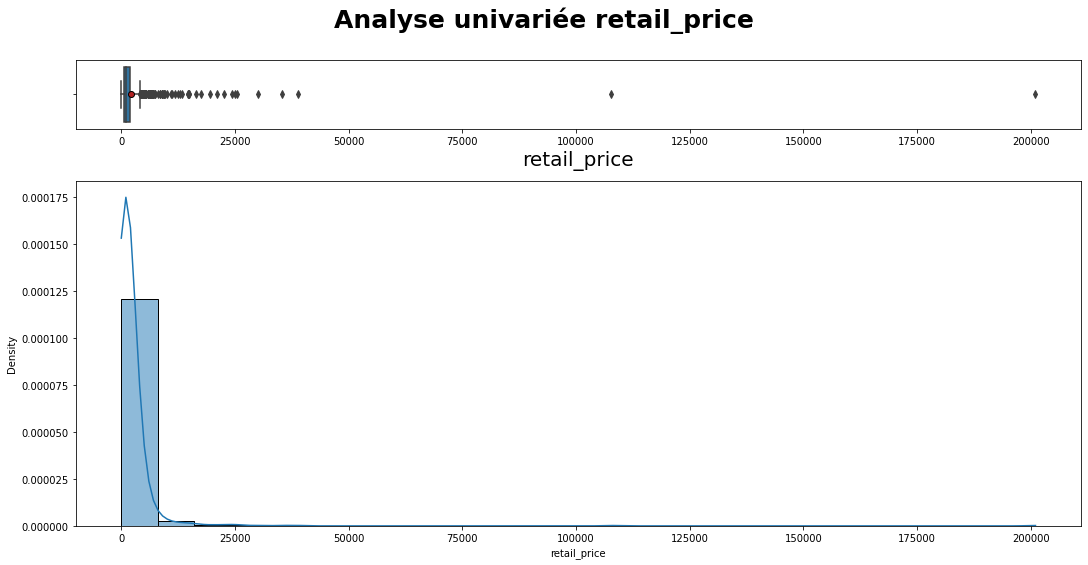

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


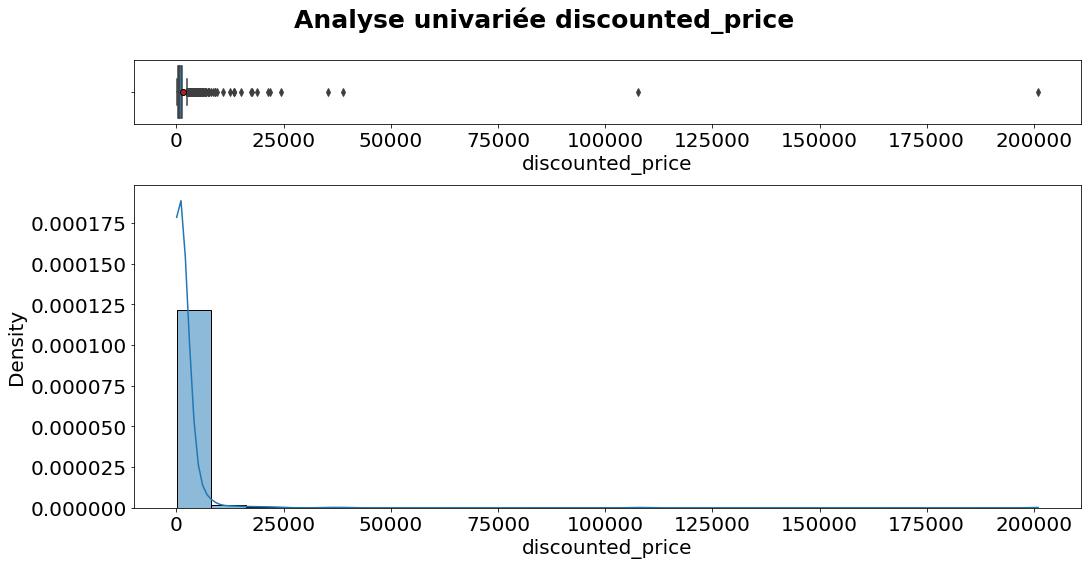

In [ ]:
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
SIZE=20

for var in colonne_numerique:
    fig = plt.figure(constrained_layout=True, figsize=[15,7])
    fig.suptitle("Analyse univariée "+var, size=25, fontweight="bold", y=1.1)
    spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])
    ax_box = fig.add_subplot(spec[0, :])
    ax_hist = fig.add_subplot(spec[1, :])
    sns.boxplot(df_analyse[var], meanprops=meanprops, showmeans=True, ax=ax_box)
    sns.histplot(df_analyse[var], bins=25,  kde=True, stat="density",  ax=ax_hist)
    ax_box.set_xlabel(var, size=20)
    
    plt.rc('axes', labelsize=SIZE) 
    plt.rc('xtick', labelsize=SIZE)
    plt.rc('ytick', labelsize=SIZE) 
    plt.rc('legend', fontsize=SIZE)
    plt.savefig("Analyse_univariée_total_"+var, bbox_inches='tight',format='png')
    plt.show()
    

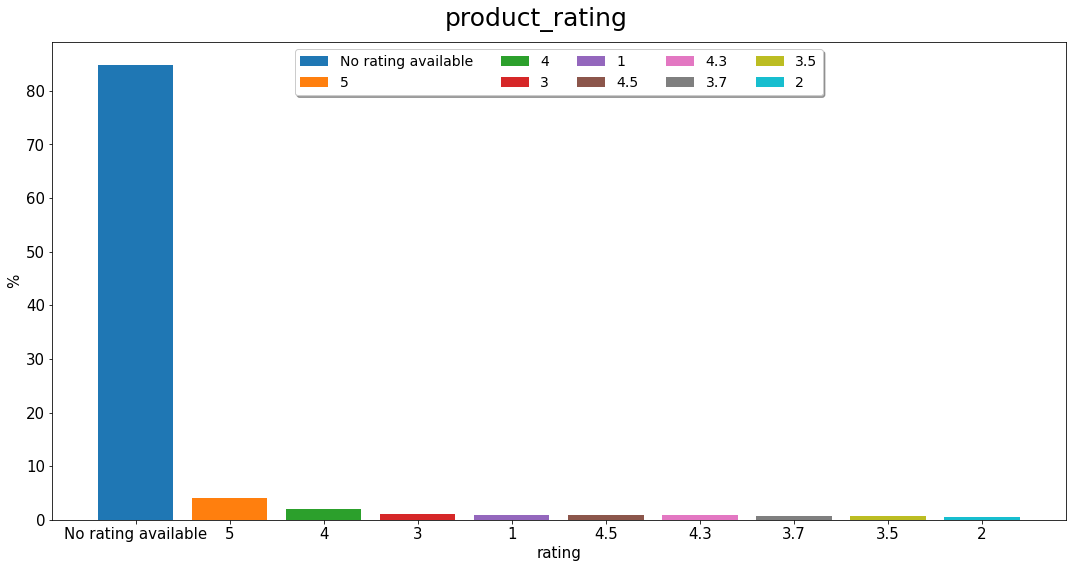

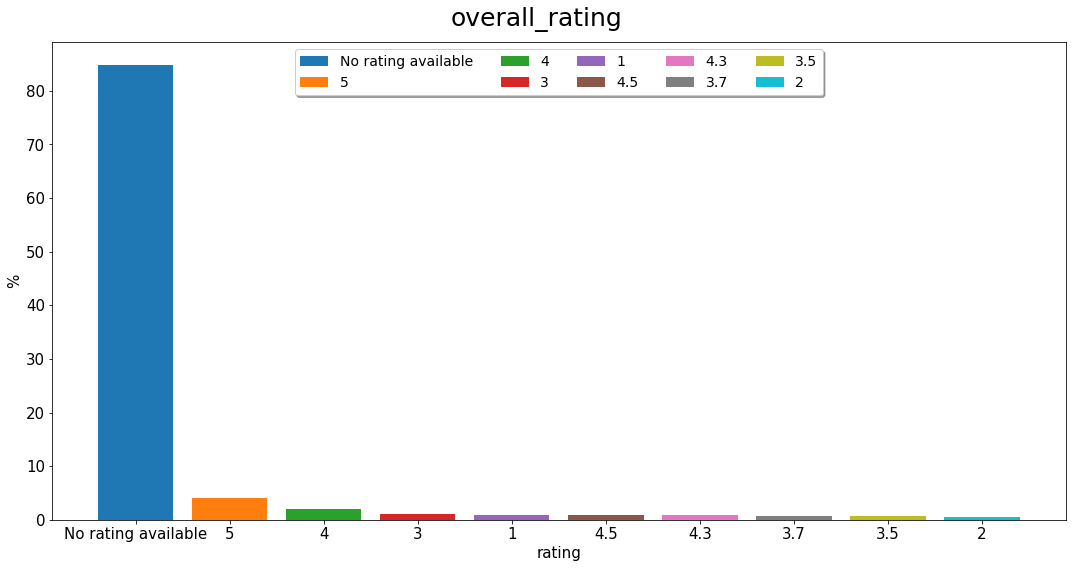

In [8]:
SIZE=15
for var in ["product_rating", "overall_rating"]:
    donnees= (
        df_analyse[var].value_counts().sort_values(ascending=False).values*100/1048
    )
    labels = df_analyse[var].value_counts().sort_values(ascending=False).index
    #labels = ["5.0", "4.0", "1.0", "3.0", "2.0"]
    textprops = {"size": "16", "color": "blue", "backgroundcolor": "white"}
    colors = sns.color_palette()
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[15, 8])

    fig.suptitle(var, size=25)
    for x, data, color in zip(labels, donnees, colors):
        ax1.bar(x, data, label=x, color=color)
    ax1.legend(
        loc="upper center",
        ncol=5,
        fontsize=14,
        fancybox=True,
        shadow=True,
    )
    #ax1.set_title("tuyaux d'orgues", fontsize=14)
    # ax1.axis('off')
    ax1.set_xlabel("rating") 
    ax1.set_ylabel("%") 
    plt.rc('axes', labelsize=SIZE) 
    plt.rc('xtick', labelsize=SIZE)
    plt.rc('ytick', labelsize=SIZE) 
    plt.rc('legend', fontsize=SIZE)

    plt.tight_layout()
    plt.savefig("fig/Ana_univariee_"+var+".png", bbox_inches="tight", format="png")
    plt.show()

Les résultats montre:
 * On retrouve une distribution unimodale avec dyssimétrie à gauche (valeurs très concentrés) pour les prix des produits "discount" et "retails"
 * la note globale et la note du produit ont les même pourcentage de répartition des notes  (même variables?)
 

## Ajustement du fichier d'analyse 


In [ ]:
df_analyse_ranting=df_analyse[["product_rating", "overall_rating"]]
df_analyse_ranting['ratio'] = df_analyse_ranting.apply(lambda row: fuzz.partial_ratio(row['product_rating'],
                                                                                           row['overall_rating']), axis=1)

In [ ]:
df_analyse_ranting["ratio"].describe()

Les 2 variables sont bien identiques

In [11]:
df_analyse=df_analyse.drop(["overall_rating"], axis=1)
df_analyse.shape

(1050, 9)

In [12]:
df_analyse["product_category_tree"][0].split(">>")

['["Home Furnishing ',
 ' Curtains & Accessories ',
 ' Curtains ',
 ' Elegance Polyester Multicolor Abstract Eyelet Do..."]']

In [13]:
df_analyse["product_category_tree"][0].split(">>")

['["Home Furnishing ',
 ' Curtains & Accessories ',
 ' Curtains ',
 ' Elegance Polyester Multicolor Abstract Eyelet Do..."]']

In [14]:
df_analyse["target_1"]=df_analyse["product_category_tree"].apply(lambda x :x.split('>>')[0][2:len(x.split(">>")[0])])
df_analyse["target_1"][0]

'Home Furnishing '

In [15]:
# retirer l'espace
df_analyse["target_1"]=df_analyse["target_1"].apply(lambda x :x.strip())


In [16]:
df_analyse["target_2"]=df_analyse["product_category_tree"].apply(lambda x :x.split('>>')[1][2:len(x.split(">>")[1])])

df_analyse["target_2"]=df_analyse["target_2"].apply(lambda x :x.strip())

In [18]:
print("le nombre d'élement unique  de target_1 est {} et de target 2 est {}".format(len(df_analyse["target_1"].unique()), 
                                                                                    len(df_analyse["target_2"].unique())))

le nombre d'élement unique  de target_1 est 7 et de target 2 est 63


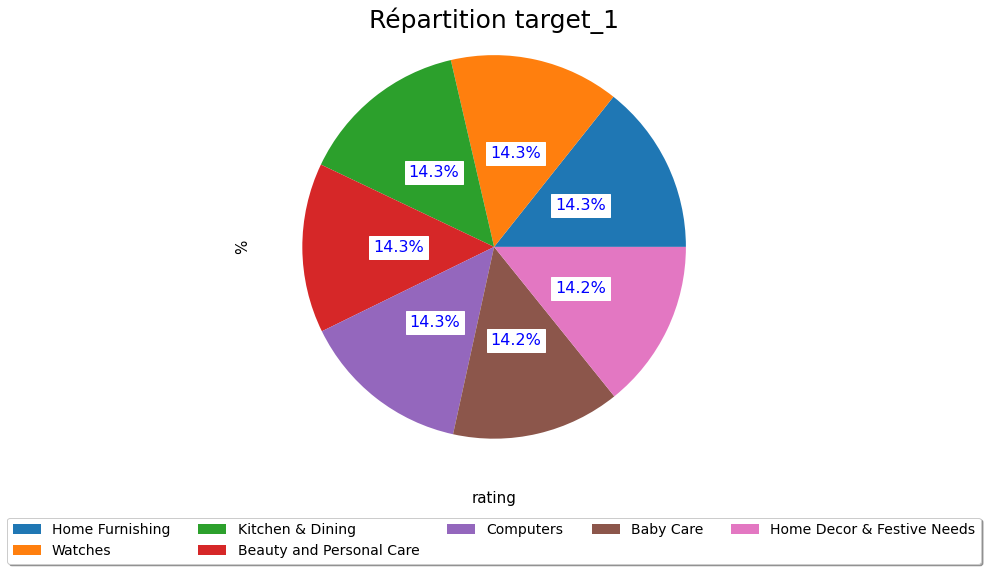

In [ ]:
SIZE=15
var="target_1"
donnees= (
    df_analyse[var].value_counts().sort_values(ascending=False).values*100/1048
)
labels = df_analyse[var].value_counts().sort_values(ascending=False).index
#labels = ["5.0", "4.0", "1.0", "3.0", "2.0"]
textprops = {"size": "16", "color": "blue", "backgroundcolor": "white"}
colors = sns.color_palette()
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[15, 8])

fig.suptitle("Répartition target_1", size=25)

ax1.pie(x=donnees,  autopct="%1.1f%%", pctdistance=0.5, 
        textprops=textprops, colors=colors, startangle=0)
ax1.legend(labels, loc="upper center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), 
           fancybox=True, shadow=True)

ax1.set_xlabel("rating") 
ax1.set_ylabel("%") 
plt.rc('axes', labelsize=SIZE) 
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE)

plt.tight_layout()
images_dir = '/content/drive/My Drive/P6_DIALLO_Fatoumata/fig'
plt.savefig(f"{images_dir}/Ana_univariee_"+var+".png", bbox_inches="tight", format="png")
plt.show()

Avec Target 1 les images ont une proportion pratiquement égale

# III/ Analyses des images avec SIFT

In [6]:
list_photos =[df_analyse["image"].values[i] for i in range(len(df_analyse))]
print(len(list_photos))

1050


In [21]:
print(df_analyse["image"].values[3],"\n",list_photos[3])

d4684dcdc759dd9cdf41504698d737d8.jpg 
 d4684dcdc759dd9cdf41504698d737d8.jpg


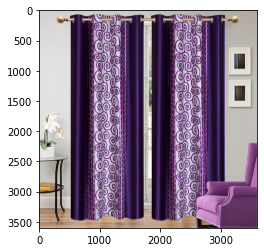

In [22]:
link_image= link+ "Images/"
filename=link_image+ list_photos[0]

image = imread(filename)
plt.imshow(image)

In [23]:
df_analyse["weight"]=df_analyse["image"].apply(lambda x :Image.open(link_image+x).size[0])
df_analyse["height"]=df_analyse["image"].apply(lambda x :Image.open(link_image+x).size[1])

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [24]:
df_etude=df_analyse[["image","weight","height","target_1"]]
#df_etude=df_analyse[["image","target_1"]]
le = preprocessing.LabelEncoder()
df_etude["label"] = le.fit_transform(df_etude["target_1"])
df_etude

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,image,weight,height,target_1,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,3600,3600,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,2388,1293,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,982,729,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,1100,831,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,2670,2088,Home Furnishing,4
...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,1100,937,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,900,1200,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,1100,1011,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,900,1200,Baby Care,0


In [25]:
print("pour weight la valeur min et max sont :",df_etude["weight"].min(),df_etude["weight"].max())
print("pour height la valeur min et max sont :",df_etude["height"].min(),df_etude["height"].max())

pour weight la valeur min et max sont : 145 8484
pour height la valeur min et max sont : 160 11042


In [26]:
foo=Image.open(link_image+list_photos[0])
foo=foo.resize((224,224),Image.ANTIALIAS)
foo.save(link_image+"Red_"+list_photos[0],quality=95)

In [7]:
list_photos_Red=[]
for i in list_photos:
  foo=Image.open(link_image+i)
  foo=foo.resize((224,224),Image.ANTIALIAS)
  foo.save(link_image+"Red_"+i,quality=95)
  list_photos_Red.append("Red_"+i)


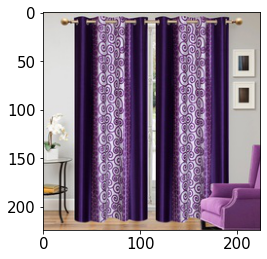

In [ ]:
filename=link_image+ "Red_"+list_photos[0]

image = imread(filename)
plt.imshow(image)

In [28]:
df_etude["Red_image"]=df_etude["image"].apply(lambda x: "Red_"+ x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_etude

,image,weight,height,target_1,label,Red_image
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,3600,3600,Home Furnishing,4,Red_55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,2388,1293,Baby Care,0,Red_7b72c92c2f6c40268628ec5f14c6d590.jpg
3,d4684dcdc759dd9cdf41504698d737d8.jpg,1100,831,Home Furnishing,4,Red_d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,2670,2088,Home Furnishing,4,Red_6325b6870c54cd47be6ebfbffa620ec7.jpg
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,1086,1770,Watches,6,Red_893aa5ed55f7cff2eccea7758d7a86bd.jpg
...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,1100,937,Baby Care,0,Red_958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,900,1200,Baby Care,0,Red_fd6cbcc22efb6b761bd564c28928483c.jpg
1047,5912e037d12774bb73a2048f35a00009.jpg,1100,1011,Baby Care,0,Red_5912e037d12774bb73a2048f35a00009.jpg
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,900,1200,Baby Care,0,Red_c3edc504d1b4f0ba6224fa53a43a7ad6.jpg


### III-1/ Analyse de 2 images aléatoires de montre

In [ ]:
df_etude[df_etude["target_1"]=="Watches"]

,image,weight,height,target_1,label,Red_image
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,1086,1770,Watches,6,Red_893aa5ed55f7cff2eccea7758d7a86bd.jpg
6,f355cc1ccb08bd0d283ed979b7ee7515.jpg,1130,1593,Watches,6,Red_f355cc1ccb08bd0d283ed979b7ee7515.jpg
7,dd0e3470a7e6ed76fd69c2da27721041.jpg,651,1000,Watches,6,Red_dd0e3470a7e6ed76fd69c2da27721041.jpg
8,41384da51732c0b4df3de8f395714fbb.jpg,318,510,Watches,6,Red_41384da51732c0b4df3de8f395714fbb.jpg
9,710ed5f2393a4b9e8823aa0029f71f93.jpg,416,784,Watches,6,Red_710ed5f2393a4b9e8823aa0029f71f93.jpg
...,...,...,...,...,...,...
796,170fdf050c7a1f8d30ef5a98c4216f9c.jpg,870,1390,Watches,6,Red_170fdf050c7a1f8d30ef5a98c4216f9c.jpg
823,697ad1d2e45c1af54cab7847cbe324d8.jpg,1672,1380,Watches,6,Red_697ad1d2e45c1af54cab7847cbe324d8.jpg
825,3a7b224bf1bc9cee9052f9c9df0355f6.jpg,1141,1046,Watches,6,Red_3a7b224bf1bc9cee9052f9c9df0355f6.jpg
826,700dfd088162ea00deda33123cd7f2da.jpg,839,1360,Watches,6,Red_700dfd088162ea00deda33123cd7f2da.jpg


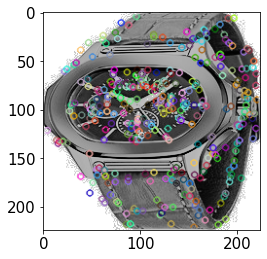

Descripteurs :  (388, 128)

[[ 14.   0.   0. ...   0.   0.   0.]
 [ 31.  11.   0. ...   0.   0.   4.]
 [ 31.  47.   5. ...   0.   0.   1.]
 ...
 [136.  45.   6. ...   0.   0.   1.]
 [  1.   0.   0. ...   0.   0.   0.]
 [  5.   4.  37. ...   0.   0.   1.]]


In [ ]:
#conversion et equalization
sift = cv2.xfeatures2d.SIFT_create()
#surf=cv2.xfeatures2d.SURF_create(500)
image = cv2.imread(link_image+"Red_893aa5ed55f7cff2eccea7758d7a86bd.jpg",0) # convert in gray
image_equalize = cv2.equalizeHist(image)   # equalize image histogram

#création des descripteurs
kp_1, des_1 = sift.detectAndCompute(image_equalize, None)

img_1=cv2.drawKeypoints(image_equalize,kp_1,image_equalize)
plt.imshow(img_1)
plt.show()
print("Descripteurs : ", des_1.shape)
print()
print(des_1)

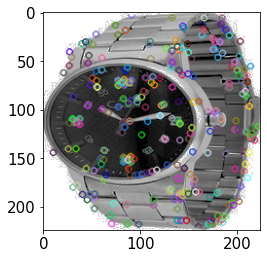

Descripteurs :  (288, 128)

[[164.  13.   0. ...   3.   2.   0.]
 [107.   0.   0. ...   0.   2.  11.]
 [ 41.  42.   1. ...   0.   0.   0.]
 ...
 [ 46.   3.   0. ...   0.  10.  35.]
 [ 50.   8.   3. ...   0.   1.  11.]
 [ 45.   0.   0. ...   0.   0.   8.]]


In [ ]:
#conversion et equalization
sift = cv2.xfeatures2d.SIFT_create()
#surf=cv2.xfeatures2d.SURF_create(500)
image = cv2.imread(link_image+"Red_f355cc1ccb08bd0d283ed979b7ee7515.jpg",0) # convert in gray
image_equalize = cv2.equalizeHist(image)   # equalize image histogram

#création des descripteurs
kp_2, des_2 = sift.detectAndCompute(image_equalize, None)

img_2=cv2.drawKeypoints(image_equalize,kp_2,image_equalize)
plt.imshow(img_2)
plt.show()
print("Descripteurs : ", des_2.shape)
print()
print(des_2)

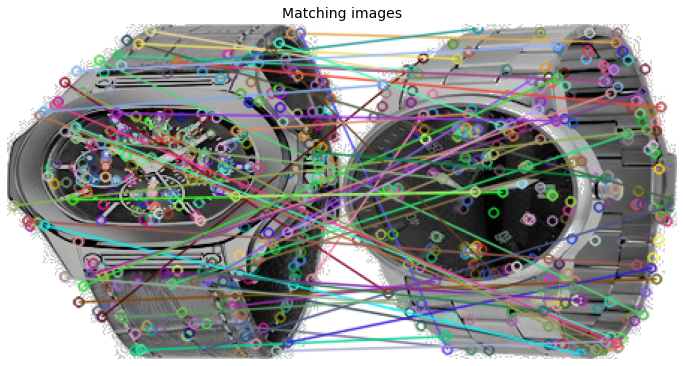

In [ ]:
bf_macher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches= bf_macher.match(des_1, des_2)
matches = sorted(matches, key=lambda x: x.distance)
image_3 = cv2.drawMatches(img_1, kp_1, img_2, kp_2,
                               matches[:50], None, flags=2)

plt.figure(figsize=(12, 8))
plt.imshow(image_3)
plt.grid(None)
plt.axis("off")
plt.title("Matching images", fontsize=14)
plt.show()


## III-2/ Création des features et histogramme des images

In [9]:
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create()

for image_num in range(len(list_photos_Red)) :
  ####""boucle sur les étapes cruciales""
  image = cv2.imread(link_image+list_photos_Red[image_num],0) # convert in gray
  image_equalize = cv2.equalizeHist(image)   # equalize image histogram

  #création des descripteurs
  kp, des = sift.detectAndCompute(image_equalize, None)

  #assemblage des listes
  sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints) #tableaux des listes==matrice
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)
duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")


Nombre de descripteurs :  (339157, 128)
temps de traitement SIFT descriptor :           821.90 secondes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [10]:
#creation des clusters

# Determination number of clusters/features ou variables à utiliser
temps1=time.time()

k = int(np.sqrt(len(sift_keypoints_all)))
print("Nombre de clusters estimés : ", k)

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=10)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  582
temps de traitement kmeans :             8.00 secondes


In [11]:
###histogramme des images
#fonction
def histogram_image(kmeans, des, image):
    predict_des = kmeans.predict(des) #mettre les labels
    histogramme = np.zeros(len(kmeans.cluster_centers_))
    size_des=len(predict_des) #taille de descripteur qui varient suivant l'image
    if size_des==0 : print("problème histogramme image  : ", image)
    for i in predict_des:
        histogramme[i] += 1.0/size_des
    return histogramme


# Creation de la matrice d'histogramme
histogramme_vectors=[]
for i, descripteur_img in enumerate(sift_keypoints_by_img) :
    histogramme = histogram_image(kmeans, descripteur_img, i) #calculates the histogram
    histogramme_vectors.append(histogramme) #histogram is the feature vector

#creation du tableau des liste d'histogramme==matrice
features_image = np.asarray(histogramme_vectors)

print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

temps de création histogrammes :             8.00 secondes


### III-3/ Réduction de dimension : PCA  & TSNE

###a) PCA

In [12]:
features_image

array([[0.0234375 , 0.        , 0.        , ..., 0.00260417, 0.        ,
        0.00520833],
       [0.00819672, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00167504, 0.00167504, ..., 0.        , 0.00167504,
        0.0318258 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0021978 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00220751, 0.        ,
        0.        ]])

In [13]:
df_features_image= pd.DataFrame(features_image)

In [14]:
#decomposition et transformation des variables sur le plan des composantes principales (reduire features)
print("Dimensions dataset avant réduction PCA : ", df_features_image.shape)
#diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
pca = decomposition.PCA(n_components=131)
df_features_image_transforme= pca.fit_transform(df_features_image)
print("Dimensions dataset après réduction PCA : ", df_features_image_transforme.shape)

Dimensions dataset avant réduction PCA :  (1050, 582)
Dimensions dataset après réduction PCA :  (1050, 131)


In [15]:
#decomposition et transformation des variables sur le plan des composantes principales (reduire features)
print("Dimensions dataset avant réduction PCA : ", features_image.shape)
#diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (95%)
pca = decomposition.PCA(n_components=.95)
features_image_transforme= pca.fit_transform(features_image)
print("Dimensions dataset après réduction PCA : ", features_image_transforme.shape)

Dimensions dataset avant réduction PCA :  (1050, 582)
Dimensions dataset après réduction PCA :  (1050, 338)


In [ ]:
features_image_transforme

array([[ 0.00871491, -0.01080627, -0.01212429, ...,  0.00015758,
         0.00116856, -0.00198659],
       [-0.00607476,  0.00190845,  0.00421653, ..., -0.00116907,
         0.0006127 ,  0.00241299],
       [-0.00035029, -0.02746917,  0.00936709, ...,  0.00149731,
        -0.00060156, -0.00047394],
       ...,
       [-0.00139762, -0.02311135, -0.00331857, ..., -0.00262554,
         0.00265612,  0.0009769 ],
       [-0.00918521,  0.01053531, -0.0023131 , ..., -0.00160097,
        -0.00184773,  0.0003664 ],
       [-0.00068289, -0.02776863, -0.00286996, ..., -0.00158436,
        -0.00278081, -0.00012437]])

### b) TSNE avec target_1 ( classe prédéfinis)

In [16]:
#Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(features_image_transforme)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
print(df_tsne.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1050, 2)


In [17]:
df_tsne[["target_1","label"]]=df_etude[["target_1","label"]].values

In [19]:
nombre_target=len(df_etude["target_1"].unique())

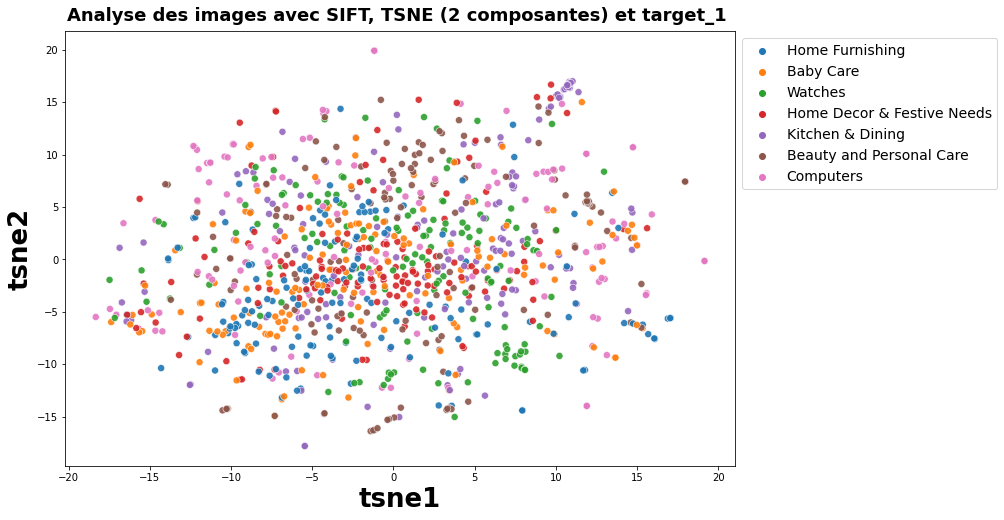

In [20]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="target_1", data=df_tsne,
     palette=sns.color_palette("tab10", n_colors=nombre_target), s=50, alpha=0.9)

#plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={"size": 14})
plt.title("Analyse des images avec SIFT, TSNE (2 composantes) et target_1 ", fontsize=18,
              pad=10, fontweight="bold")
plt.savefig(f"{images_dir}/Ana_SIFT_TSNE_target.png", bbox_inches="tight", format="png")

plt.show()

Le target_1 choisi ne permet pas de distinguer les clusters

### c) TSNE avec clustering

In [ ]:
cls = cluster.KMeans(n_clusters=nombre_target, random_state=10)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

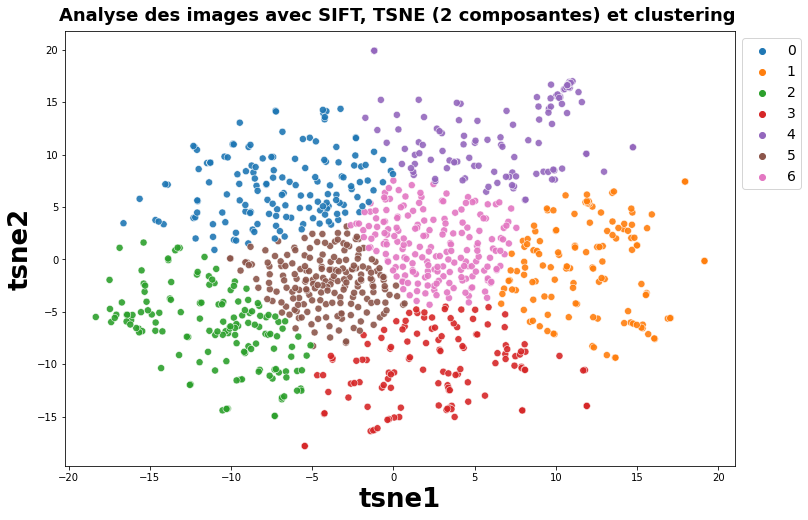

In [22]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne,
     palette=sns.color_palette("tab10", n_colors=nombre_target), s=50, alpha=0.9)

#plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={"size": 14})
plt.title("Analyse des images avec SIFT, TSNE (2 composantes) et clustering ", fontsize=18,
              pad=10, fontweight="bold")

plt.savefig(f"{images_dir}/Ana_SIFT_TSNE_Cluster.png", bbox_inches="tight", format="png")

plt.show()

In [87]:
print("ARI : ", metrics.adjusted_rand_score(df_tsne["label"].values, df_tsne["cluster"].values))

ARI :  0.043838985582722596


La valeur de ARI est très faible. Ce qui était attendu au  vu de l'image

La distinction est beaucoup plus affiné. On arrive à faire la part entre les 7 clusters

In [24]:
df_etude["cluster_sift"]=df_tsne["cluster"].values

In [25]:
repertoire="drive/My Drive/P6_DIALLO_Fatoumata/"
df_etude.to_csv('df_etude.csv', encoding='utf-8',index=False)
df_tsne.to_csv('df_tsne.csv', encoding='utf-8',index=False)
#df_VGG16.to_csv('df_VGG16.csv', encoding='utf-8',index=False)
#df_tsne_VGG16.to_csv('df_tsne_VGG16.csv', encoding='utf-8',index=False)

#pour le drive google colab
!cp df_etude.csv "drive/My Drive/P6_DIALLO_Fatoumata/"
!cp df_tsne.csv "drive/My Drive/P6_DIALLO_Fatoumata/"
#!cp df_VGG16.csv "drive/My Drive/P6_DIALLO_Fatoumata/"
#!cp df_tsne_VGG16.csv "drive/My Drive/P6_DIALLO_Fatoumata/"

In [3]:
df_analyseCluster=df_etude.groupby(["cluster_sift", "target_1"]).agg({ "cluster_sift":"count"})
df_analyseCluster.columns=["nombre"]
df_analyseCluster=df_analyseCluster.reset_index()

In [24]:
pip install plotly==5.3.1

Note: you may need to restart the kernel to use updated packages.


In [5]:
# restart le kernel avant pour write
import plotly
plotly.__version__

'5.3.1'

In [9]:
import plotly.express as px
from plotly.subplots import make_subplots
#methode plus simple mais pas possible de le mettre sur 2 axes

figure=plt.figure(constrained_layout=True, figsize=[20,15])
fig = px.line_polar(df_analyseCluster, r='nombre', theta='target_1',  color="cluster_sift", line_close=True, color_discrete_sequence=px.colors.qualitative.G10)
fig.update_traces(fill='toself')
fig.update_layout(
    polar=dict(
        radialaxis=dict(
                        visible=True
                    )
            ),
    title=" Analyse de la proportion des cluster sift en fonction des catégories (target_1)",
    
    font=dict(
        color='black',
        size=18, #can change the size of font here
        family='Times New Roman'
             ),
    
autosize=True
)
#fig.write_image(("fig/radar_chart_cluster_sift_px.png")
fig.show()
fig.write_image("fig/radar_chart_cluster_sift_px.png" )


<Figure size 1440x1080 with 0 Axes>

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

compt_1=range(3)
compt_2=range(3,7)
colors_1=["blue", "brown", "green"]
colors_2=["red","lightyellow", "lightpink", "cyan"]

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'polar'}]*2])
for i,color in zip(compt_1, colors_1):
  fig.add_trace(go.Scatterpolar(
        name = str(i),
        r = df_analyseCluster[df_analyseCluster['cluster_sift']==i]['nombre'],
        theta = df_analyseCluster[df_analyseCluster['cluster_sift']==i]['target_1'],
        fill='toself',
        fillcolor=color, opacity=0.6,
        showlegend=True,
      legendgrouptitle=dict(text="cluster_sfit"), legendgroup = "cluster_sfit",
      ), 1, 1)

for i,color in zip(compt_2, colors_2): 
  fig.add_trace(go.Scatterpolar(
        name = str(i),
        r = df_analyseCluster[df_analyseCluster['cluster_sift']==i]['nombre'],
        theta = df_analyseCluster[df_analyseCluster['cluster_sift']==i]['target_1'],
        fill='toself',
        fillcolor=color, opacity=0.6,
        showlegend=True,
    ),
      1, 2)

fig.update_layout(
    polar=dict(
        radialaxis=dict(
                        visible=True
                    )
            ),
    title=" Analyse de la proportion des cluster sift en fonction des catégories (target_1)",
    
    font=dict(
        color='black',
        size=18, #can change the size of font here
        family='Times New Roman'
             ),
    
autosize=False,
    width=1700,
    height=700,
)

#images_dir = '/content/drive/My Drive/P6_DIALLO_Fatoumata/fig'
#plt.savefig(f"{images_dir}/radar_chart_cluster_sift.png", bbox_inches="tight", format="png")
#plt.savefig("fig/radar_chart_cluster_sift_go.pdf", bbox_inches="tight", format="pdf")
fig.show()
fig.write_image("fig/radar_chart_cluster_sift_go.png")

In [ ]:
repertoire="drive/My Drive/P6_DIALLO_Fatoumata/"
df_etude.to_csv('df_etude.csv', encoding='utf-8',index=False)
df_tsne.to_csv('df_tsne.csv', encoding='utf-8',index=False)

#pour le drive google colab
!cp df_etude.csv "drive/My Drive/P6_DIALLO_Fatoumata/"
!cp df_tsne.csv "drive/My Drive/P6_DIALLO_Fatoumata/"


In [ ]:
link="/content/drive/My Drive/P6_DIALLO_Fatoumata/Flipkart/"
link_image= link+ "Images/"
images_dir = '/content/drive/My Drive/P6_DIALLO_Fatoumata/fig'
repertoire_etude="/content/drive/My Drive/P6_DIALLO_Fatoumata/"
file_tsne= open(repertoire_etude + "df_tsne.csv")
file_etude=open(repertoire_etude + "df_etude.csv")

df_tsne = pd.read_csv(file_tsne)
df_etude = pd.read_csv(file_etude)

nombre_target=len(df_etude['target_1'])


In [2]:
#sur jupyter
repertoire_etude="/home/bdiallo/Documents/OPENCLASSROOM/P6_DIALLO_Fatoumata/"
file_tsne= open(repertoire_etude + "df_tsne.csv")
file_etude=open(repertoire_etude + "df_etude.csv")
file_analyse=open(repertoire_etude + "df_analyse.csv")

df_tsne = pd.read_csv(file_tsne)
df_etude = pd.read_csv(file_etude)
df_analyse = pd.read_csv(file_analyse)

nombre_target=len(df_etude['target_1'])

# IV/ Etude avec CNN : VGG16

In [ ]:
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## Création du modèle d'étude avec VGG16

In [ ]:
model_etude_1 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_etude_2 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_etude_1.trainable=False
model_etude_2.trainable=True
pooling_layer=model_etude_2.layers[-5]
flatten_layer = Flatten()

model_etude=Sequential([model_etude_1, pooling_layer,flatten_layer, Dense(nombre_target, activation='softmax', dtype='float32')
])
model_etude.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## Conversion des images et entrainenemt du modèle

In [ ]:
tableau_image=[]
for i in range(1048) :
    #img_etude = imread(link_image+df_etude.Red_image.values[i])
    #table_etude=img_to_array(img_etude)
    img_etude = cv2.imread(link_image+df_etude.Red_image.values[i])
    table_etude=cv2.resize(img_etude, (224, 224))
    tableau_image.append(table_etude) #ajout features

#creation de la matrice
matrice_image = np.asarray(tableau_image)

In [ ]:
y_target=np.array(df_etude['label'])

In [ ]:
matrice_image.shape, y_target.shape

((1048, 224, 224, 3), (1048,))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(matrice_image, y_target,test_size=0.2, random_state=1)

In [ ]:
x_train.shape, y_train.shape

((838, 224, 224, 3), (838,))

In [ ]:
#epochs nombre d'itération
model_etude.fit(x_train, y_train, epochs=10, verbose=-1)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


## Prédiction

In [ ]:
model_etude.evaluate(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4942: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


7/7 [==============================] - 109s 15s/step - loss: 11.5115 - accuracy: 0.7143


[11.511494636535645, 0.7142857313156128]

In [ ]:
y_predict = model_etude.predict(x_test) # en float
y_predict_label = [np.argmax(element) for element in y_predict] # en integer
print('classfication report:' , metrics.classification_report(y_test, y_predict_label))

classfication report:               precision    recall  f1-score   support

           0       0.54      0.45      0.49        29
           1       0.76      0.64      0.70        25
           2       0.74      0.82      0.78        34
           3       0.59      0.77      0.67        30
           4       0.61      0.55      0.58        31
           5       0.83      0.74      0.78        27
           6       0.92      0.97      0.94        34

    accuracy                           0.71       210
   macro avg       0.71      0.71      0.70       210
weighted avg       0.71      0.71      0.71       210



In [174]:
classes=[df_etude[df_etude['label']== i ]['target_1'].values[0]for i in range(7)]

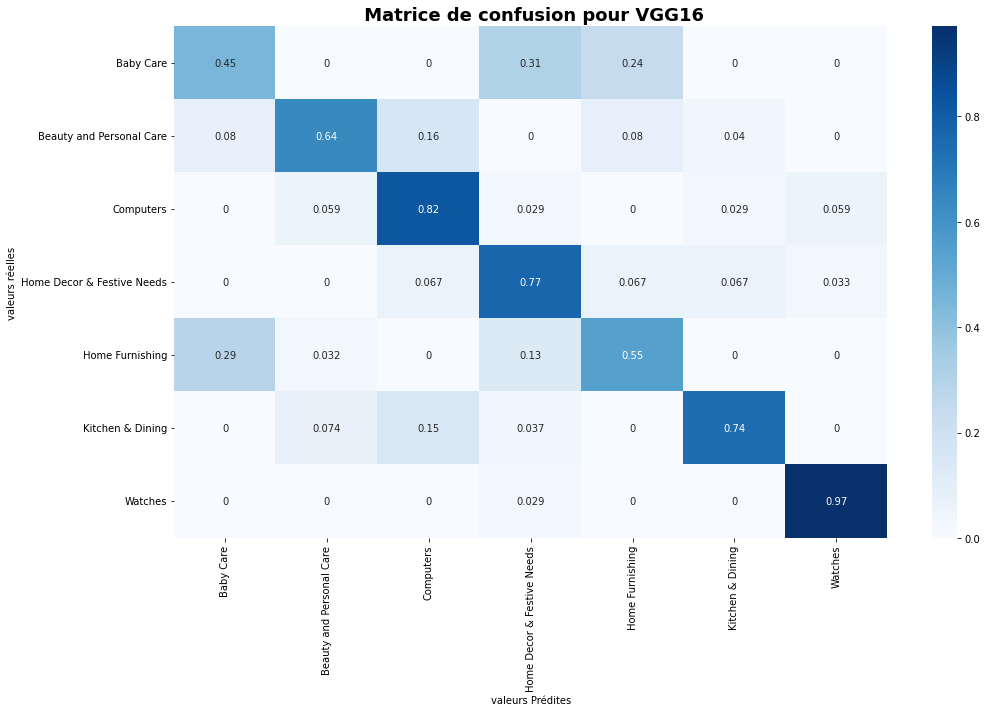

ARI score: 0.501
Accuracy classification score:  71.43


In [177]:

#matrice de confusion
ari=metrics.adjusted_rand_score(y_test,y_predict_label)
df_Confusionmatrix = confusion_matrix(y_test,y_predict_label, normalize='true')

df_Confusionmatrix = pd.DataFrame(df_Confusionmatrix, index=classes,
                         columns=classes)
df_Confusionmatrix.index.name = 'valeurs réelles'
df_Confusionmatrix.columns.name = 'valeurs Prédites'
plt.figure(figsize = (15, 10))
plt.title(" Matrice de confusion pour VGG16", fontsize=18, fontweight="bold")  
sns.heatmap(df_Confusionmatrix, annot=True, cmap="Blues") # cmap="rocket_r"

plt.tight_layout()
plt.savefig(f"{images_dir}/matrice_confusion_VGG16.png", bbox_inches="tight", format="png")
plt.show()

print("ARI score:", str(round(ari, 3)))
print("Accuracy classification score: ", str(round(metrics.accuracy_score(y_test,y_predict_label)*100, 2)))


## Exemple de classification

In [156]:
def feature_extraction(link, image_num, model):
    #chargement image
    image = load_img(link+"Red_"+image_num, target_size=(224, 224))
    
    # Transformation
    image = img_to_array(image) #conversion en tableau
    image = np.expand_dims(image, axis=0) # création échantillon
    image = preprocess_input(image)  # Prétraiter l'image comme le veut VGG-16

    # preditions
    prediction_VGG16 = model.predict(image, use_multiprocessing=True)
    label_predict_VGG16 = np.argmax(prediction_VGG16[0],axis=0)

    return label_predict_VGG16,prediction_VGG16

In [159]:
df_etude.image.values[0]

'55b85ea15a1536d46b7190ad6fff8ce7.jpg'

In [176]:
index_0, predict_0=feature_extraction(link_image,df_etude.image.values[0],model_etude)
print("la valeur du label prédit de cette image est ", index_0)
print("La catégorie donc prédite cette image est", classes[index_0])

la valeur du label prédit de cette image est  4
La catégorie donc prédite cette image est Home Furnishing


In [161]:
df_etude[df_etude['image']=="55b85ea15a1536d46b7190ad6fff8ce7.jpg"]

,image,weight,height,target_1,label,Red_image,VGG16,cluster_sift
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,3600,3600,Home Furnishing,4,Red_55b85ea15a1536d46b7190ad6fff8ce7.jpg,[0. 0. 0. ... 0. 0. 0.],4
